# Inversion of NLTE profiles with RT


### Here we will invert a profiles obtained with a code of self consistent RT in NLTE and without flat spectrum aproximation.

In [1]:
import numpy as np
import hazel
import matplotlib.pyplot as plt
import h5py
# from astropy.io import fits

In [2]:
# Let's define the files and parameters of the run
datadir = "/home/avicente/Documents/flat_spectrum/output_hazel_B_10.0_90.0_0.0_z300.0mM_20221103-161822/"
std = 0.0003
basefile_inversion = "10830_nlte"

# Then finally we can set up the parameters of the model. In order of appearence, these are:
# height of the slab above the solar surface (given here,in arcseconds).
# mu = cos(theta) LOS direction
# phi azimuthal angle of the LOS (in degrees)
# Bx, By, Bz, magnetic field in the cartesian (heliocentric) coordinates 
# Optical depth of the red component (tau)
# LOS velocity
# Thermal velocity
# Beta, which is an ad-hoc parameter used to explain 'unusual' profiles (e.g. in flares) 
# Damping
# Filling factor (provided separately) - only used in the case when we have multiple slabs, lying horizontally 
# next to eeach other, and occupying the same pixel

height = 30000/725.0
mu = 1.0
phi = 0.0
Bx = 10.0
By = 0.0
Bz = 0.0
tau = 2.1702701290223905 # 1.0890165862290955
vlos = 0.0
vth = np.sqrt(8.0*1.38065e-23*2.0e4/(np.pi*4.0*1.66054e-27))/1.e3
beta = 1.0
a = 0.01
ff = 1.0

In [3]:
# print the parameters
print("height = ", height)
print("mu = ", mu)
print("phi = ", phi)
print("Bx = ", Bx)
print("By = ", By)
print("Bz = ", Bz)
print("tau = ", tau)
print("vlos = ", vlos)
print("vth = ", vth)
print("beta = ", beta)
print("a = ", a)
print("ff = ", ff)

height =  41.37931034482759
mu =  1.0
phi =  0.0
Bx =  10.0
By =  0.0
Bz =  0.0
tau =  2.1702701290223905
vlos =  0.0
vth =  10.28897678066648
beta =  1.0
a =  0.01
ff =  1.0


In [4]:
# Let's first load a profile:
data = np.loadtxt(f"{datadir}out/stokes_00.out",skiprows=3,unpack=True)

# constrain the wavelengths used for the test to the central ones (where the profile is)
length = data.shape[1]
p1 = int(length/7)
p3 = int(p1*6)
data = data[:,p1:p3]

# invert the wavelength axis to be increasing
data = data[:,::-1]

In [5]:
# Convert from space to air wavelengths
s = 1e4/np.copy(data[0])/1e-10
n = 1 + 0.0000834254 + 0.02406147 / (130 - s**2) + 0.00015998 / (38.9 - s**2)
ll = 299792458/np.copy(data[0])/10e-11/n

# copy, normalize the data and add noise
noise = np.random.normal(0, std, data[1:5].shape)
stokes_to_fit = np.copy(data[1:5])/data[1,0] + noise

noise_observed = np.ones_like(stokes_to_fit)*std

# make sure the shapes are the intended
print(ll.shape, stokes_to_fit.shape, noise.shape, data.shape)

(265,) (4, 265) (4, 265) (5, 265)


Text(0.5, 0, 'Wavelength')

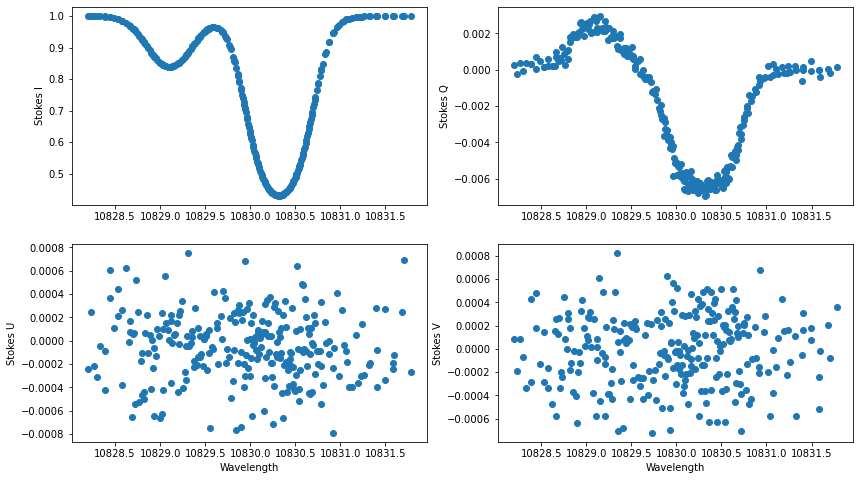

In [6]:
# Let's visualize these profiles: 
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes_to_fit[0,:],'o')
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes_to_fit[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes_to_fit[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes_to_fit[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

### We will go straight to the inversion, we know what we need to do! 

In [7]:
# First the wavelength axis
n_wvl = len(ll)
np.savetxt(f'{basefile_inversion}.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open(f'{basefile_inversion}.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

f = open(f'{basefile_inversion}.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'0.0 0.0 90.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes_to_fit, noise_observed]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

In [8]:
# Check again the shapes
tmp.shape, n_wvl, stokes_to_fit.shape

((8, 265), 265, (4, 265))

In [9]:
# Run the inversion with the previously saved files
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model(f'{basefile_inversion}.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=1)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-11-03 17:33:10,640 - Hazel2 v1.0
2022-11-03 17:33:10,641 - Using configuration from file : 10830_nlte.ini
2022-11-03 17:33:10,644 - Backtracking mode : brent
2022-11-03 17:33:10,644 - Adding spectral region spec1
2022-11-03 17:33:10,645 -   - Reading wavelength axis from 10830_nlte.wavelength
2022-11-03 17:33:10,646 -   - Reading wavelength weights from 10830_nlte.weights
2022-11-03 17:33:10,648 -   - Using observations from 10830_nlte.1d
2022-11-03 17:33:10,649 -   - No mask for pixels
2022-11-03 17:33:10,649 -   - No instrumental profile
2022-11-03 17:33:10,650 -   - Using LOS ['0.0', '0.0', '90.0']
2022-11-03 17:33:10,650 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2022-11-03 17:33:10,651 - Using 3 cycles
2022-11-03 17:33:10,652 - Using analytical RFs if possible : False
2022-11-03 17:33:10,652 - Using 10 max. iterations
2022-11-03 17:33:10,652 - Not using randomizations
2022-11-03 17:33:10,653 - Stopping when relative error is below 1e-05
2022-11-03 17:33:10,65

In [10]:
# copy the result and check the shape
result = h5py.File(f'output_{basefile_inversion}.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(1,4,n_wvl)
fit.shape

(1, 4, 265)

### Result of the inversion (orange line) and NLTE profile (blue dots)

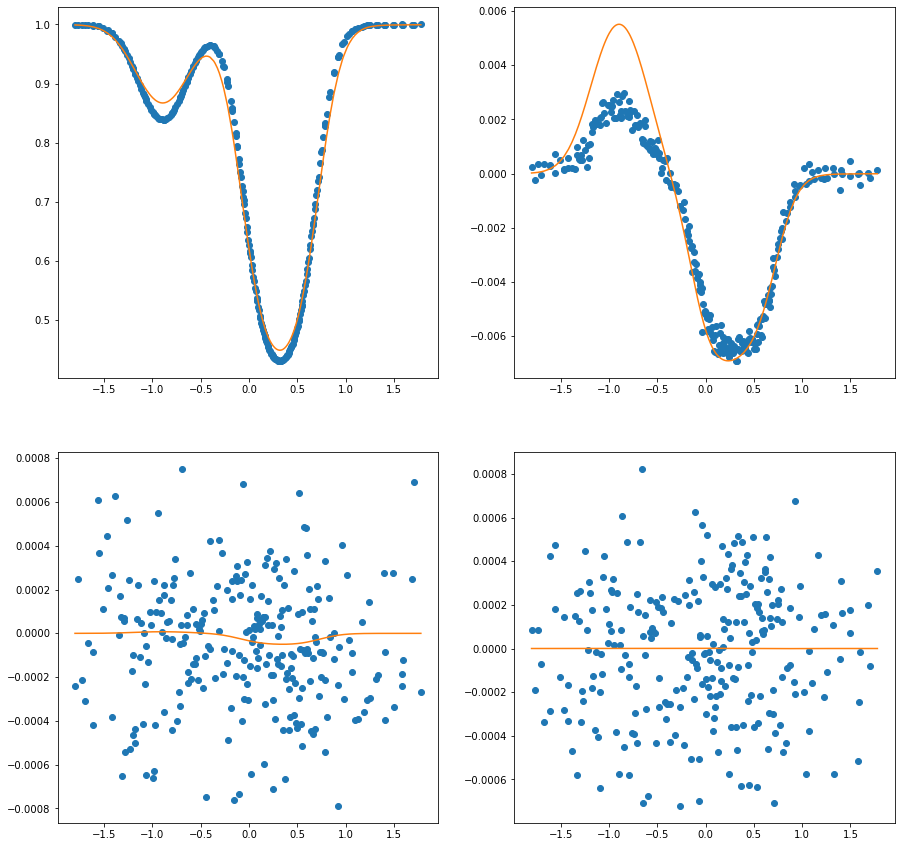

In [11]:
plt.figure(figsize=[15,15])
plt.subplot(221)
plt.plot(ll-10830,stokes_to_fit[0,:],'o')
plt.plot(ll-10830,fit[0,0,:])
# plt.ylim([0, 1.05])
plt.subplot(222)
plt.plot(ll-10830,stokes_to_fit[1,:],'o')
plt.plot(ll-10830,fit[0,1,:])
# plt.ylim([-0.0075, 0.0075])
plt.subplot(223)
plt.plot(ll-10830,stokes_to_fit[2,:],'o')
plt.plot(ll-10830,fit[0,2,:])
# plt.ylim([-0.0075, 0.0075])
plt.subplot(224)
plt.plot(ll-10830,stokes_to_fit[3,:],'o')
plt.plot(ll-10830,fit[0,3,:])
# plt.ylim([-0.0075, 0.0075])

In [12]:
result['ch1'].keys()
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0])
print ("By= ",result['ch1']['By'][0,0,0])
print ("Bz= ",result['ch1']['Bz'][0,0,0])
print ("tau= ",result['ch1']['tau'][0,0,0])
print ("vlos ",result['ch1']['v'][0,0,0])
print ("vtherm= ",result['ch1']['deltav'][0,0,0])
print ("beta= ",result['ch1']['beta'][0,0,0])
print ("a= ",result['ch1']['a'][0,0,0])
result.close()

Bx=  0.34402575701240323
By=  -0.0018755838054279588
Bz=  0.009999877116507955
tau=  1.656162320504263
vlos  0.3773046223518577
vtherm=  10.289
beta=  1.0
a=  0.010000000000000002


## SYNTHESIS WITH THE SAME PARAMETERS AS THE ORIGINAL LINE

In [13]:
# We will first create a model:
mod = hazel.Model(working_mode='synthesis')

# The model contains the information about the desired wavelength grid, the so called 'topology', line of sight, and the boundary condition:
mod.add_spectral({'Name': 'spec1', 'Wavelength': [ll.min(), ll.max(), len(ll)], 'topology': 'ch1',
    'LOS': [np.arccos(mu), phi, 90.0], 'Boundary condition': [1.0,0.0,0.0,0.0]})

# It also contains the general information about our "chromosphere"
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': height, 'Line': '10830', 'Wavelength': [10826, 10833]})
mod.setup()

mod.atmospheres['ch1'].set_parameters([Bx,By,Bz,tau,vlos,vth,beta,a],ff)
print("Synthesizing with Bx= ",Bx)
mod.synthesize()

stokes_real = np.copy(mod.spectrum['spec1'].stokes)
wave_real = mod.spectrum['spec1'].wavelength_axis

mod.atmospheres['ch1'].set_parameters([Bx/10,By,Bz,tau,vlos,vth,beta,a],ff)
print("Synthesizing with Bx= ",Bx/10)
mod.synthesize()

stokes_1 = np.copy(mod.spectrum['spec1'].stokes)
wave_1 = mod.spectrum['spec1'].wavelength_axis

mod.atmospheres['ch1'].set_parameters([Bx*10,By,Bz,tau,vlos,vth,beta,a],ff)
print("Synthesizing with Bx= ",Bx*10)
mod.synthesize()

stokes_100 = np.copy(mod.spectrum['spec1'].stokes)
wave_100 = mod.spectrum['spec1'].wavelength_axis

Synthesizing with Bx=  10.0
Synthesizing with Bx=  1.0
Synthesizing with Bx=  100.0


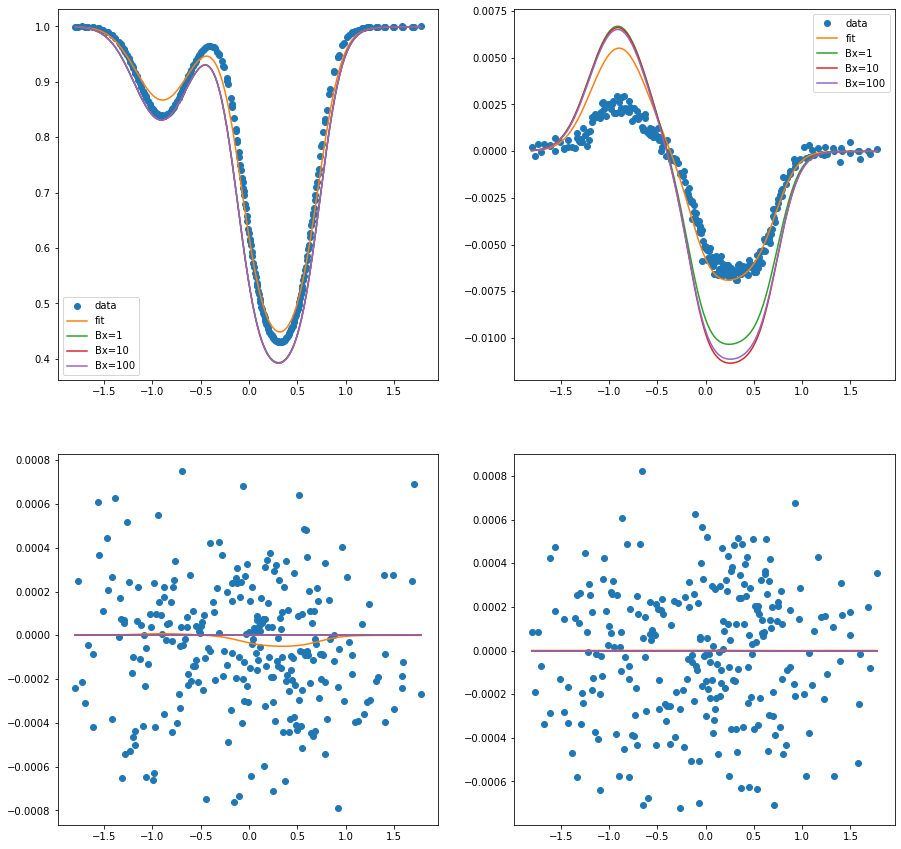

In [14]:
plt.figure(figsize=[15,15])
plt.subplot(221)
plt.plot(ll-10830,stokes_to_fit[0,:],'o')
plt.plot(ll-10830,fit[0,0,:])
plt.plot(wave_1-10830,stokes_1[0,:])
plt.plot(wave_real-10830,stokes_real[0,:])
plt.plot(wave_100-10830,stokes_100[0,:])
# plt.ylim([0.0, 1.05])
plt.legend(['data','fit','Bx=1','Bx=10','Bx=100'])
plt.subplot(222)
plt.plot(ll-10830,stokes_to_fit[1,:],'o')
plt.plot(ll-10830,fit[0,1,:])
plt.plot(wave_1-10830,stokes_1[1,:])
plt.plot(wave_real-10830,stokes_real[1,:])
plt.plot(wave_100-10830,stokes_100[1,:])
# plt.ylim([-0.012, 0.012])
plt.legend(['data','fit','Bx=1','Bx=10','Bx=100'])
plt.subplot(223)
plt.plot(ll-10830,stokes_to_fit[2,:],'o')
plt.plot(ll-10830,fit[0,2,:])
plt.plot(wave_1-10830,stokes_1[2,:])
plt.plot(wave_real-10830,stokes_real[2,:])
plt.plot(wave_100-10830,stokes_100[2,:])
# plt.ylim([-0.012, 0.012])
plt.subplot(224)
plt.plot(ll-10830,stokes_to_fit[3,:],'o')
plt.plot(ll-10830,fit[0,3,:])
plt.plot(wave_1-10830,stokes_1[3,:])
plt.plot(wave_real-10830,stokes_real[3,:])
plt.plot(wave_100-10830,stokes_100[3,:])
# plt.ylim([-0.012, 0.012])

### NOW WE CAN CHECK HOW THE PEAKS RATIO CHANGES WITH OPTICAL DEPTH IN COMPARISON WITH OUR NLTE SELF CONSISTEN SOLUTION 

In [15]:
# We will first create a model:
mod = hazel.Model(working_mode='synthesis')

# The model contains the information about the desired wavelength grid, the so called 'topology', line of sight, and the boundary condition:
mod.add_spectral({'Name': 'spec1', 'Wavelength': [ll.min(), ll.max(), len(ll)], 'topology': 'ch1',
    'LOS': [np.arccos(mu), phi, 90.0], 'Boundary condition': [1.0,0.0,0.0,0.0]})

# It also contains the general information about our "chromosphere"

mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': height, 'Line': '10830', 'Wavelength': [10826, 10833]})
mod.setup()

# plt.figure(figsize=[16,8])
taus = np.arange(0.1,20,0.1)
ratios = []
for num, tau in enumerate(taus):
    
    mod.atmospheres['ch1'].set_parameters([Bx,By,Bz,tau,vlos,vth,beta,a],ff)
    mod.synthesize()

    stokes = np.copy(mod.spectrum['spec1'].stokes)
    wave = mod.spectrum['spec1'].wavelength_axis

    indx_peak_red = np.abs(wave -10830 + 0.95).argmin()
    indx_peak_blue = np.abs(wave -10830 - 0.3).argmin()

    ratios.append((1 - stokes[0,indx_peak_blue])/(1 - stokes[0,indx_peak_red]))
    
    if tau%1 < 0.01 and tau < 10:
        # plt.subplot(121)
        # plt.plot(wave-10830,stokes[0,:])
        pass

# plt.ylim([0.0, 1.05])
# plt.subplot(122)
# plt.plot(taus, ratios, label='constant property slab')
    
# tau, ratios = np.loadtxt('/home/avicente/Documents/flat_spectrum/peaks_tau_analytical.txt', unpack=True)
# plt.plot(tau, ratios, label='self consistent NLTE')
# plt.legend()
# plt.show()